<a href="https://colab.research.google.com/github/lunaB/Pytorch-Study/blob/master/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 실행후 런타임 다시시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,360 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and d

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [75]:
df = pd.DataFrame([["i love you", "ich liebe dich"],
                    ["i love myself", "ich liebe mich"],
                    ["i like you", "ich mag dich"],
                    ["he love you", "er liebt dich"]], columns=['src', 'tar'])
df

,src,tar
0,i love you,ich liebe dich
1,i love myself,ich liebe mich
2,i like you,ich mag dich
3,he love you,er liebt dich


In [76]:
SOS_token = 0
EOS_token = 1

class Tokenizer:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
    
    def to_seq(self, sentence):
        l = []
        for s in sentence.split(" "):
            l.append(self.vocab2index[s])
        return l

In [104]:
src_tok = Tokenizer()
for s in df['src'].values:
    for v in s.split(' '):
        src_tok.add_vocab(v)

tar_tok = Tokenizer()
for s in df['tar'].values:
    for v in s.split(' '):
        tar_tok.add_vocab(v)

print(src_tok.vocab2index)
print(tar_tok.vocab2index)

{'<SOS>': 0, '<EOS>': 1, 'i': 2, 'love': 3, 'you': 4, 'myself': 5, 'like': 6, 'he': 7}
{'<SOS>': 0, '<EOS>': 1, 'ich': 2, 'liebe': 3, 'dich': 4, 'mich': 5, 'mag': 6, 'er': 7, 'liebt': 8}


In [105]:
src_data = [src_tok.to_seq(s) for s in df['src'].values]
tar_data = [[SOS_token] + tar_tok.to_seq(s) + [EOS_token] for s in df['tar'].values]
print(src_data)
print(tar_data)

[[2, 3, 4], [2, 3, 5], [2, 6, 4], [7, 3, 4]]
[[0, 2, 3, 4, 1], [0, 2, 3, 5, 1], [0, 2, 6, 4, 1], [0, 7, 8, 4, 1]]


In [106]:
# hparam
hparam = {}
hparam['embed_size'] = 8

In [107]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(src_tok.n_vocab, hparam['embed_size']) # embed_size = 4
        self.rnn = nn.LSTM(input_size=hparam['embed_size'], hidden_size=hparam['embed_size'])

    def forward(self, x, h, c):
        # (1)
        x = self.embed(x)
        # (embed_size)
        x = x.view((1, 1, -1))
        # (1,1,embed_size)
        x, (h, c) = self.rnn(x, (h, c))
        # (1,1,embed_size) (1,1,embed_size) (1,1,embed_size)
        return h, c

In [108]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(tar_tok.n_vocab, hparam['embed_size']) # embed_size = 4
        self.rnn = nn.LSTM(input_size=hparam['embed_size'], hidden_size=hparam['embed_size'])

    def forward(self, x, h, c):
        # (1)
        x = self.embed(x)
        # (embed_size)
        x = x.view((1, 1, -1))
        # (1,1,embed_size)
        x, (h, c) = self.rnn(x, (h, c))
        # (1,1,embed_size) (1,1,embed_size) (1,1,embed_size)
        return h, c

In [109]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.wc = nn.Linear(hparam['embed_size'] * 2, hparam['embed_size']) # (embed_size * 2, embed_size) = (8, 4)
        self.tanh = nn.Tanh()
        self.wy = nn.Linear(hparam['embed_size'], tar_tok.n_vocab) # (embed_size, word_cnt)
    def forward(self, x):
        # (1,1,embed_size * 2)
        x = self.wc(x)
        # (1,1,embed_size)
        x = self.tanh(x)
        # (1,1,embed_size)
        x = self.wy(x)
        # (1,1,word_cnt)
        x = F.log_softmax(x, dim=2)
        # (1,1,word_cnt)
        return x

In [115]:
encoder = Encoder()
decoder = Decoder()
attention = Attention()

enc_optimizer = optim.RMSprop(encoder.parameters(), lr=0.01)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=0.01)
att_optimizer = optim.RMSprop(attention.parameters(), lr=0.01)
criterion = nn.NLLLoss()

loss_hist = []
for epoch in range(500):
    loss_avg = []

    for batch in range(len(src_data)):

        loss = 0

        src_train = torch.LongTensor(src_data[batch])

        h, c = torch.zeros((1, 1, hparam['embed_size'])), torch.zeros((1, 1, hparam['embed_size']))
        # (1,1,embed_size) (1,1,embed_size)

        enc_out = torch.Tensor([])
        # (src_len, 1, embed_size)
        for i in range(len(src_train)):
            # x = (1)
            h, c = encoder(src_train[i], h, c)
            # (1,1,embed_size) (1,1,embed_size)
            enc_out = torch.cat((enc_out, h))

        tar_train = torch.LongTensor(tar_data[batch])

        sent = []

        # teaching force rate
        rate = 0.5

        # teaching force
        if rate > np.random.rand():
            for i in range(len(tar_train[:-1])):
                h, c = decoder(tar_train[i], h, c)
                # (1,1,embed_size) (1,1,embed_size)
                score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
                # t 시점 state의 encoder h attention score
                # (src_len, 1, 1) = score(hn, stT)
                att_dis = F.softmax(score, dim=0)
                # Attention Distribution
                # (src_len,1,1)
                att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
                # Attention Value
                # (1,1,embed_size)
                con = torch.cat((att_v, h), dim=2)
                # Concatinate
                out = attention(con)
                # (1,1,word_cnt)
                loss += criterion(out.view((1, -1)), tar_train[i+1].view(1))

                sent.append(tar_tok.index2vocab[out.argmax().detach().item()])

        # without teaching force
        else:
            dec_in = tar_train[0]
            # skalar
            for i in range(len(tar_train[:-1])):
                h, c = decoder(dec_in, h, c)
                score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
                att_dis = F.softmax(score, dim=0)
                att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
                con = torch.cat((att_v, h), dim=2)
                out = attention(con)
                topv, topi = out.squeeze().topk(1) # detach!
                # (1), (1)
                dec_in = topi[0].detach()
                # skalar
                loss += criterion(out.view((1, -1)), tar_train[i+1].view(1))
                
                sent.append(tar_tok.index2vocab[out.argmax().detach().item()])
                if dec_in == EOS_token:
                    break
        
        if (epoch + 1) % 50 == 0:
            print(epoch + 1, batch, loss.item())
            print(' '.join([tar_tok.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]))
            print(' '.join(sent))
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        att_optimizer.zero_grad()

        loss = loss / len(df)
        loss.backward()

        enc_optimizer.step()
        dec_optimizer.step()
        att_optimizer.step()

        loss_avg.append(loss.item())

    loss_hist.append(sum(loss_avg))

    if (epoch + 1) % 50 == 0:
        print('avg loss', loss_hist[-1])
        print('=============================')

50 0 0.14833630621433258
ich liebe dich <EOS>
ich liebe dich <EOS>
50 1 0.2763829529285431
ich liebe mich <EOS>
ich liebe mich <EOS>
50 2 0.15102164447307587
ich mag dich <EOS>
ich mag dich <EOS>
50 3 0.20915456116199493
er liebt dich <EOS>
er liebt dich <EOS>
avg loss 0.19622386619448662
100 0 0.03028861992061138
ich liebe dich <EOS>
ich liebe dich <EOS>
100 1 0.04911121726036072
ich liebe mich <EOS>
ich liebe mich <EOS>
100 2 0.03375150263309479
ich mag dich <EOS>
ich mag dich <EOS>
100 3 0.04313572123646736
er liebt dich <EOS>
er liebt dich <EOS>
avg loss 0.03907176526263356
150 0 0.007999850437045097
ich liebe dich <EOS>
ich liebe dich <EOS>
150 1 0.014074131846427917
ich liebe mich <EOS>
ich liebe mich <EOS>
150 2 0.009901531040668488
ich mag dich <EOS>
ich mag dich <EOS>
150 3 0.013088466599583626
er liebt dich <EOS>
er liebt dich <EOS>
avg loss 0.011265994980931282
200 0 0.002717508003115654
ich liebe dich <EOS>
ich liebe dich <EOS>
200 1 0.004773566033691168
ich liebe mich <EOS

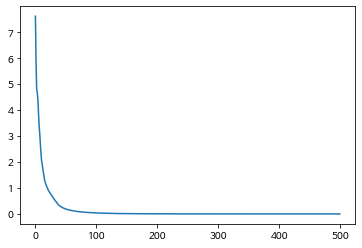

In [116]:
plt.plot(loss_hist)
plt.show()

In [117]:
def evaluation(batch):
    src_train = torch.LongTensor(src_data[batch])

    h, c = torch.zeros((1, 1, hparam['embed_size'])), torch.zeros((1, 1, hparam['embed_size']))
    # (1,1,embed_size) (1,1,embed_size)

    enc_out = torch.Tensor([])
    # (src_len, 1, embed_size)
    for i in range(len(src_train)):
        # x = (1)
        h, c = encoder(src_train[i], h, c)
        # (1,1,embed_size) (1,1,embed_size)
        enc_out = torch.cat((enc_out, h))

    tar_train = torch.LongTensor(tar_data[batch])

    sent = []
    att_met = []

    dec_in = tar_train[0]
    # skalar
    for i in range(len(tar_train[:-1])):
        h, c = decoder(dec_in, h, c)
        score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
        att_dis = F.softmax(score, dim=0)

        att_met.append(att_dis.detach().numpy().reshape((-1)).tolist()) # visualization

        att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
        con = torch.cat((att_v, h), dim=2)
        out = attention(con)
        topv, topi = out.squeeze().topk(1) # detach!
        # (1), (1)
        dec_in = topi[0].detach()
        
        sent.append(tar_tok.index2vocab[out.argmax().detach().item()])
        # if dec_in == EOS_token:
        #     break
    
    s_arr = [src_tok.index2vocab[t] for t in src_train.detach().numpy()]
    t_arr = [tar_tok.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]
    
    print(' '.join(s_arr))
    print(' '.join(t_arr))
    print(' '.join(sent))

    return att_met, s_arr, t_arr

In [118]:
def visualization(test_case):
    att_met, s_arr, t_arr = evaluation(test_case)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    c = ax.matshow(np.array(att_met).T, cmap='bone')

    ax.set_xticks(np.arange(len(t_arr)))
    ax.set_yticks(np.arange(len(s_arr)))

    ax.set_xticklabels(t_arr)
    ax.set_yticklabels(s_arr)

    fig.colorbar(c)
    plt.show()

i love you
ich liebe dich <EOS>
ich liebe dich <EOS>


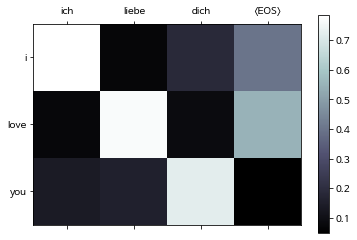

i love myself
ich liebe mich <EOS>
ich liebe mich <EOS>


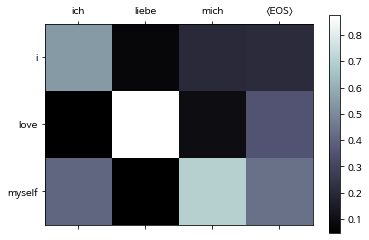

i like you
ich mag dich <EOS>
ich mag dich <EOS>


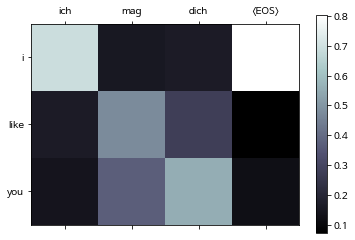

he love you
er liebt dich <EOS>
er liebt dich <EOS>


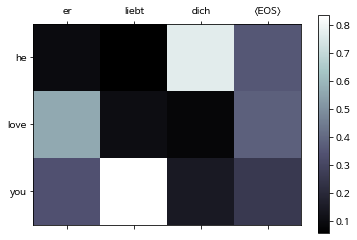

In [119]:
for i in range(4):
    visualization(i)